In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import shap

In [2]:
import os
for dirname, _, filenames in os.walk('Input/'):
    for filename in filenames:
        print(filename)
        print(os.path.join(dirname, filename))

Kaggle_Sirio_Libanes_ICU_Prediction.csv
Input/COVID-19 - Clinical Data to assess diagnosis\Kaggle_Sirio_Libanes_ICU_Prediction.csv
Kaggle_Sirio_Libanes_ICU_Prediction.xlsx
Input/COVID-19 - Clinical Data to assess diagnosis\Kaggle_Sirio_Libanes_ICU_Prediction.xlsx


- Can we predict which inpatient will need intensive care unit (ICU)?

- What is the best time window for each previous question. Justify.

In [3]:
pd.set_option('display.max_columns', 240)
pd.set_option('display.max_rows', 240)
raw_data = pd.read_csv('Input/COVID-19 - Clinical Data to assess diagnosis/Kaggle_Sirio_Libanes_ICU_Prediction.csv', sep = ';', decimal='.')
print(raw_data.shape)
raw_data.head()

(1925, 231)


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### There are 4 groups of features:

##### Demographics ( No–:3 )
- Percentil Age.
- Above 65 years old.
- Gender.

##### Comorbities ( No–:9 )

- The features were created based on the historical ICD-10 codes of each patient using the Charlson and Elixhauser range of comorbid conditions (https://pubmed.ncbi.nlm.nih.gov/16224307/ https://pubmed.ncbi.nlm.nih.gov/9431328/). Here, we have chosen the comorbid groups related to serious adverse outcomes in COVID-19.

##### Vital Signs ( No–:36 )

- Diastolic blood pressure.
- Systolic blood pressure.
- Heart rate.
- Respiratory rate.
- Temperature.
- Oxygen saturation.

##### Laboratory ( No–:180 )

- There are 36 laboratorys types.

### The outcome variable is ICU admission.

##### The following features were created for each vital signs and time window:

- mean
- median
- min
- max
- amplitude (diff): max-min
- relative amplitude (rel): amplitude/median

##### The following features were created for each laboratory exam and time window:

- mean
- median
- min
- max
- amplitude (diff): max-min

In [4]:
comorb_lst = [i for i in raw_data.columns if "DISEASE" in i]
comorb_lst.extend(["HTN", "IMMUNOCOMPROMISED", "OTHER"])

demo_lst = [i for i in raw_data.columns if "AGE_" in i]
demo_lst.append("GENDER")


vitalSigns_lst = raw_data.iloc[:,193:-2].columns.tolist()

lab_lst = raw_data.iloc[:,13:193].columns.tolist()

In [5]:
print(f"Number of Comorbities features: {len(comorb_lst)}") 
print(f"Number of Demographics features: {len(demo_lst)}") 
print(f"Number of Vital Signs features: {len(vitalSigns_lst)}") 
print(f"Number of Laboratory features: {len(lab_lst)}")

Number of Comorbities features: 9
Number of Demographics features: 3
Number of Vital Signs features: 36
Number of Laboratory features: 180


##### ID is a identification number for each patient.

In [6]:
print(f"Number of lines in the dataset: {len(raw_data)}")
print(f"Number of inpatients: {len(raw_data.PATIENT_VISIT_IDENTIFIER.unique())}")

Number of lines in the dataset: 1925
Number of inpatients: 385


From hospital admission, there are five time windows. Please, observe that there is a flag pointing out whether the patient was or not admitted in the ICU as well as his/her vital signs and laboratory results in that window.

In [7]:
print(raw_data.WINDOW.unique())

['0-2' '2-4' '4-6' '6-12' 'ABOVE_12']


In [8]:
raw_data.groupby("PATIENT_VISIT_IDENTIFIER", as_index = False).agg({"ICU":(list), "WINDOW":list}).iloc[[13,14,15,41,0,2]]

,PATIENT_VISIT_IDENTIFIER,ICU,WINDOW
13,13,"[0, 0, 0, 0, 1]","[0-2, 2-4, 4-6, 6-12, ABOVE_12]"
14,14,"[0, 0, 1, 1, 1]","[0-2, 2-4, 4-6, 6-12, ABOVE_12]"
15,15,"[0, 0, 0, 0, 1]","[0-2, 2-4, 4-6, 6-12, ABOVE_12]"
41,41,"[1, 1, 1, 1, 1]","[0-2, 2-4, 4-6, 6-12, ABOVE_12]"
0,0,"[0, 0, 0, 0, 1]","[0-2, 2-4, 4-6, 6-12, ABOVE_12]"
2,2,"[0, 0, 0, 0, 1]","[0-2, 2-4, 4-6, 6-12, ABOVE_12]"


In [9]:
aux = abs(raw_data.groupby("PATIENT_VISIT_IDENTIFIER")["ICU"].sum()-5)
aux = aux.value_counts().reset_index()
aux.sort_values(by = "index", inplace = True)
aux.reset_index(drop = True, inplace = True)

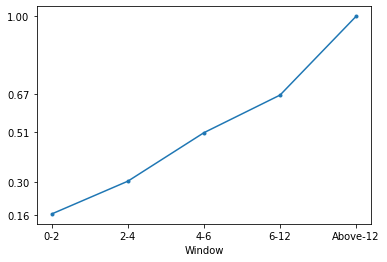

In [10]:
tot_icu_inpatients = aux.ICU[0:5].sum()
y = aux.ICU[0:5].cumsum()/tot_icu_inpatients
plt.plot(y, marker = ".")

plt.ylabel
plt.xlabel("Window")
plt.yticks(round(y,2) )
plt.xticks([0,1,2,3,4], ["0-2", "2-4", "4-6", "6-12", "Above-12"])
plt.show()

In [11]:
raw_data.isna().sum().head(20)

PATIENT_VISIT_IDENTIFIER       0
AGE_ABOVE65                    0
AGE_PERCENTIL                  0
GENDER                         0
DISEASE GROUPING 1             5
DISEASE GROUPING 2             5
DISEASE GROUPING 3             5
DISEASE GROUPING 4             5
DISEASE GROUPING 5             5
DISEASE GROUPING 6             5
HTN                            5
IMMUNOCOMPROMISED              5
OTHER                          5
ALBUMIN_MEDIAN              1104
ALBUMIN_MEAN                1104
ALBUMIN_MIN                 1104
ALBUMIN_MAX                 1104
ALBUMIN_DIFF                1104
BE_ARTERIAL_MEDIAN          1104
BE_ARTERIAL_MEAN            1104
dtype: int64

In [12]:
raw_data.dtypes.head(20)

PATIENT_VISIT_IDENTIFIER      int64
AGE_ABOVE65                   int64
AGE_PERCENTIL                object
GENDER                        int64
DISEASE GROUPING 1          float64
DISEASE GROUPING 2          float64
DISEASE GROUPING 3          float64
DISEASE GROUPING 4          float64
DISEASE GROUPING 5          float64
DISEASE GROUPING 6          float64
HTN                         float64
IMMUNOCOMPROMISED           float64
OTHER                       float64
ALBUMIN_MEDIAN               object
ALBUMIN_MEAN                 object
ALBUMIN_MIN                  object
ALBUMIN_MAX                  object
ALBUMIN_DIFF                float64
BE_ARTERIAL_MEDIAN           object
BE_ARTERIAL_MEAN             object
dtype: object

First, we'll remove the ordinal suffixes from the AGE_PERCENTIL column, so that we are left with just numbers. A simple replace to get rid of all non-digits will suffice.

In [13]:
raw_data['AGE_PERCENTIL'] = raw_data['AGE_PERCENTIL'].replace(r'[^0-9]', '', regex=True)
raw_data['AGE_PERCENTIL'].value_counts()

90    340
20    215
30    205
10    205
40    200
70    195
80    190
50    190
60    185
Name: AGE_PERCENTIL, dtype: int64

In [14]:
raw_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [15]:
def get_na_table(df):
    na_counts = pd.DataFrame([(x, df[x].isna().sum(), df[x].isna().sum()/len(df)) for x in df.columns])
    na_counts.columns = ['Variable', 'NAs', 'Percentage']
    return na_counts.sort_values(by=['NAs'], ascending=False)

In [16]:
print(get_na_table(raw_data).shape)
get_na_table(raw_data).head()

(231, 3)


,Variable,NAs,Percentage
115,P02_VENOUS_MIN,1104,0.573506
96,LEUKOCYTES_MAX,1104,0.573506
124,PC02_VENOUS_MEAN,1104,0.573506
125,PC02_VENOUS_MIN,1104,0.573506
126,PC02_VENOUS_MAX,1104,0.573506


A lot of measurments are missing. However the authors of the dataset pointed out that we can use the measurments from neighboring windows.

In [17]:
raw_data = raw_data.sort_values(by=['PATIENT_VISIT_IDENTIFIER', 'WINDOW']).groupby('PATIENT_VISIT_IDENTIFIER', as_index=False).fillna(method='ffill').fillna(method='bfill')

In [18]:
raw_data.sort_values(by=['PATIENT_VISIT_IDENTIFIER', 'WINDOW'])

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939","-0,938949939","-0,938949939",-1.0,-1,-1,-1,-1,-1.0,"0,183673469","0,183673469","0,183673469","0,18367

In [19]:
raw_data_change = raw_data.iloc[:,4:229]
raw_data_change.head()

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939","-0,938949939","-0,938949939",-1.0,-1,-1,-1,-1,-1.0,"0,183673469","0,183673469","0,183673469","0,183673469",-1.0,"-0,86836518","-0,86836518","-0,86836518","-0,86836518",-1.0,"-0,74

In [20]:
modData = raw_data_change.apply(lambda col: col.apply(lambda x : float(str(x).replace(",","."))))

In [21]:
modData

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,-0.868365,-0.868365,-0.868365,-0.868365,-1.0,-0.742004,-0.742004,-0.742004,-0.742004,-1.0,-0.945093,-0.

In [22]:
#raw_data["BE_VENOUS_MAX"].apply(lambda x : float(str(x).replace(",",".")))

In [23]:
raw_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939","-0,938949939","-0,938949939",-1.0,-1,-1,-1,-1,-1.0,"0,183673469","0,183673469","0,183673469","0,18367

In [24]:
raw_data_joined = raw_data.iloc[:,0:4]

In [25]:
raw_data_joined = raw_data_joined.join(modData)

In [26]:
raw_data_joined.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,-0.868365,-0.868365,-0.868365,-0.868

In [27]:
aux_df= raw_data.iloc[:,229:231]

In [28]:
raw_data_joined = raw_data_joined.join(aux_df)

In [29]:
raw_data_joined.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,-0.868365,-0.868365,-0.86

In [30]:
raw_data_joined.shape

(1925, 231)

In [31]:
raw_data_joined.to_csv('./output/raw_data_joined.csv')

In [32]:
# ICU per window
pd.crosstab(raw_data_joined.WINDOW, raw_data.ICU)

ICU,0,1
WINDOW,,
0-2,353,32
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


In [33]:
# Dropping the patients which were admitted to ICU in the first window
train_data = raw_data_joined.loc[~((raw_data_joined['WINDOW'] == '0-2') & (raw_data_joined['ICU'] == 1))]

In [34]:
train_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,-0.868365,-0.868365,-0.86

train_data is our dataset fully cleaned and ready to be split up in different ways to be fit into different models

In [35]:
icu_above_2 = train_data.groupby('PATIENT_VISIT_IDENTIFIER')\
    .agg({'ICU': max})\
    .reset_index()\
    .rename(columns={'ICU': 'ICU_NEW'})
    
# Merge back to original df
training_data = train_data.merge(icu_above_2, on=['PATIENT_VISIT_IDENTIFIER'], how='left')

In [36]:
training_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,-0.868365,-0.8683

In [37]:
# Valid cases per window
pd.crosstab(training_data.WINDOW, training_data.ICU)

ICU,0,1
WINDOW,,
0-2,353,0
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


In [38]:
# keep only features from 0-2 hour window
mask_02 = training_data.WINDOW == '0-2'
training_data = training_data.loc[mask_02]

# valid cases for training
pd.crosstab(training_data.WINDOW, training_data.ICU_NEW)

ICU_NEW,0,1
WINDOW,,
0-2,190,163


In [39]:
training_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,-0.868365,-0.868365,-0.868365,-0.8683

In [94]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

pipeline = [
    StandardScaler(),
    Normalizer()
]

tr = make_pipeline(*pipeline)

In [97]:
data_to_norm = raw_data_joined.iloc[:,4:229]

X_ready = tr.fit_transform(data_to_norm)
X_ready = pd.DataFrame(X_ready, columns=data_to_norm.columns)

data_dem = raw_data_joined.iloc[:,0:4]

data_middle = data_dem.join(X_ready)

aux = raw_data_joined.iloc[:,229:231]

data_norm = data_middle.join(aux)

In [98]:
data_norm

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,-0.041853,-0.020429,-0.039560,-0.017064,0.314148,0.542968,...,-0.070432,-0.039602,-0.066468,-0.067127,-0.066671,-0.061639,-0.070358,-0.039569,0-2,0
1,0,1,60,0,-0.037514,-0.018311,-0.035459,-0.015295,0.281580,0.486677,...,-0.063130,-0.035497,-0.059577,-0.060168,-0.059759,-0.055248,-0.063064,-0.035467,2-4,0
2,0,1,60,0,-0.037514,-0.018311,-0.035459,-0.015295,0.281580,0.486677,...,-0.063130,-0.035497,-0.059577,-0.060168,-0.059759,-0.055248,-0.063064,-0.035467,4-6,0
3,0,1,60,0,-0.041088,-0.020055,-0.038837,-0.016752,0.308409,0.533048,...,-0.069145,-0.038879,-0.065254,-0.065901,-0.065453,-0.060512,-0.069072,-0.038846,6-12,0
4,0,1,60,0,-0.018762,-0.009158,-0.017734,-0.007649,0.140825,0.243399,...,0.111539,0.022440,0.086509,0.178283,0.146013,0.129847,0.111372,0.023194,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50,1,-0.036946,-0.018033,-0.034922,-0.015063,-0.040631,-0.023508,...,-0.062174,-0.034959,-0.058675,-0.059257,-0.058854,-0.054412,-0.062109,-0.034930,0-2,0
1921,384,0,50,1,-0.038498,-0.018791,-0.036389,-0.015696,-0.042339,-0.024496,...,-0.064787,-0.036428,-0.061141,-0.061747,-0.061327,-0.056698,-0.064719,-0.036397,2-4,0
1922,384,0,50,1,-0.039982,-0.019516,-0.037792,-0.016302,-0.043971,-0.025440,...,-0.067284,-0.037833,-0.063498,-0.064127,-0.063692,-0.058884,-0.067214,-0.037801,4-6,0
1923,384,0,50,1,-0.035692,-0.017422,-0.033737,-0.014552,-0.039253,-0.022711,...,-0.060065,-0.033773,-0.056685,-0.057247,-0.056858,-0.052566,-0.060002,-0.033745,6-12,0


In [99]:
data_norm.to_csv('./output/raw_data_joined_normalized.csv')